In [290]:
import nltk
import datetime
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, string, time
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from PIL import Image
from wordcloud import WordCloud
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from nltk.stem import RSLPStemmer
nltk.download("stopwords");
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
from gensim.corpora.dictionary import Dictionary

[nltk_data] Downloading package stopwords to C:\Users\Breno
[nltk_data]     Ingwersen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df = pd.read_csv('base reclamações.csv', sep=';', encoding='ANSI')
df.tail()

,Regiao,estado,empresa,subsidiaria,area,serviço,problema,faixa etarea
42302,Sudeste,SP,B2W COMPANHIA DIGITAL,AMERICANAS.COM/SUBMARINO/SHOPTIME/SOUBARATO,COMÉRCIO VAREJISTA DE OUTROS PRODUTOS NÃO ESPE...,Microcomputador / Produtos de Informática,Não entrega/demora na entrega do produto,Nao Informada
42303,Sudeste,SP,ADIDAS DO BRASIL LTDA,ADIDAS.COM.BR,COMÉRCIO ATACADISTA DE CALÇADOS,Vestuário ( Calçado / Roupa ),Não entrega/demora na entrega do produto,entre 31 a 40 anos
42304,Sudeste,SP,RN COMERCIO VAREJISTA S/A,RICARDOELETRO.COM.BR/INSINUANTE.COM/ELETROSHOP...,COMÉRCIO VAREJISTA ESPECIALIZADO DE ELETRODOMÉ...,"Acessório Para Vestuário ( Bolsa, Cinto, Chapé...",Produto entregue diferente do pedido,entre 21 a 30 anos
42305,Sudeste,SP,DECOLAR.COM LTDA,AGÊNCIA DECOLAR,AGÊNCIAS DE VIAGENS,Agências e Operadoras de viagens (pacotes turí...,Recusa injustificada em prestar serviço,Nao Informada
42306,Sudeste,SP,ESAB ESCOLA SUPERIOR ABERTA DO BRASIL LTDA,NaN,EDUCAÇÃO SUPERIOR - GRADUAÇÃO E PÓS-GRADUAÇÃO,"Escola ( Pré, 1º, 2º Graus e Superior )",Serviço não fornecido (entrega/instalação/não ...,entre 31 a 40 anos


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42307 entries, 0 to 42306
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Regiao         42307 non-null  object
 1   estado         42307 non-null  object
 2   empresa        42306 non-null  object
 3   subsidiaria    35777 non-null  object
 4   area           36978 non-null  object
 5   serviço        42307 non-null  object
 6   problema       33371 non-null  object
 7   faixa etarea   42307 non-null  object
dtypes: object(8)
memory usage: 2.6+ MB


#### Removing the blank rows based on the 'problema' column

In [6]:
df = df[df['problema'].notna()]
df.isna().sum().to_frame('Quantidade de NaNs')

,Quantidade de NaNs
Regiao,0
estado,0
empresa,0
subsidiaria,5228
area,3990
serviço,0
problema,0
faixa etarea,0


#### Measuring the frequencies of the columns empresa, estado e serviço

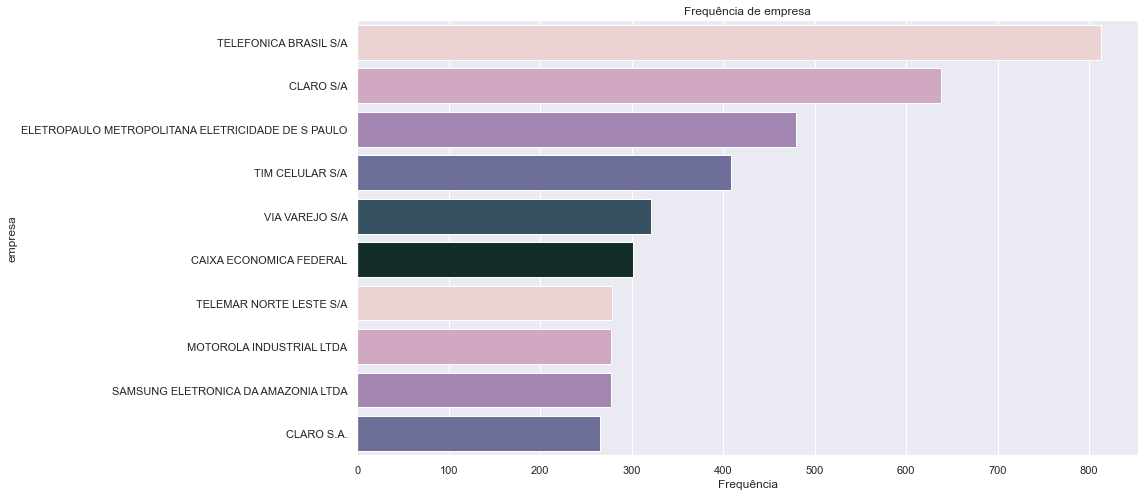

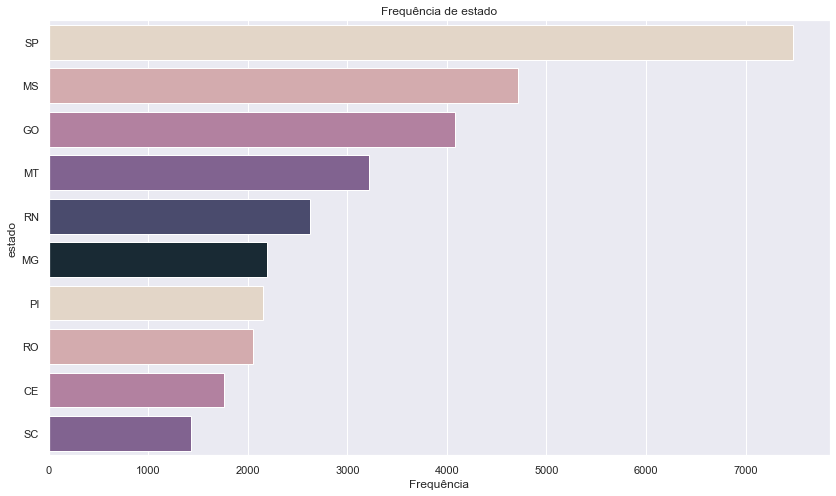

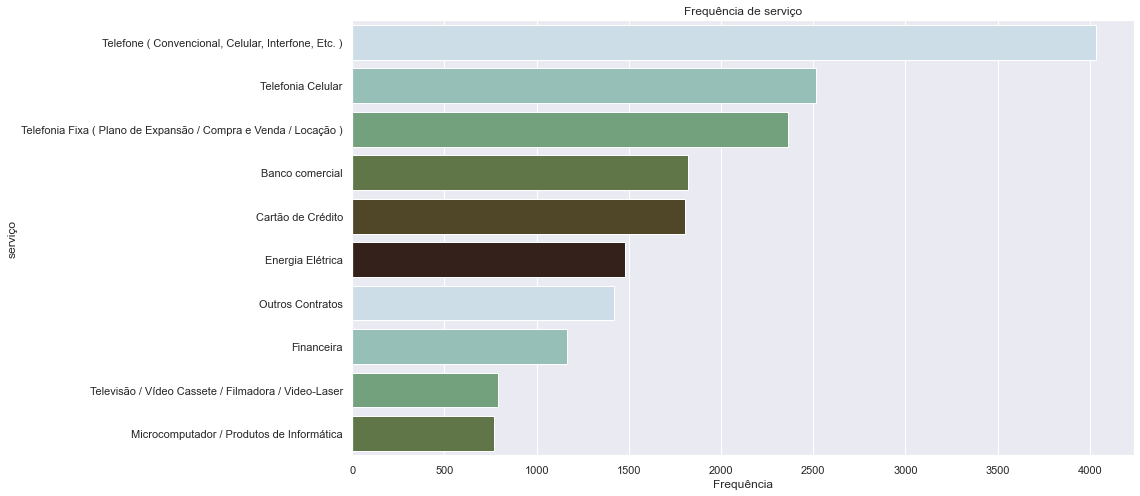

In [7]:
cols = ['empresa', 'estado', 'serviço']
for col in cols:
    sns.set(style="darkgrid", rc={'figure.figsize':(14, 8)})
    palette = sns.cubehelix_palette(start=np.random.uniform(0, 3), rot=0.75)
    ax = sns.countplot(y=col, data=df, order=df[col].value_counts().iloc[:10].index, palette=palette)
    ax.set(
        xlabel='Frequência',
        ylabel=f'{col}',
        title=f'Frequência de {col}'
    );
    plt.show()

#### Let's remove the corporation type from the "empresa" column to get a cleaner wordcloud in the end

In [8]:
l = ['sa', 'ltd', 'ltda']
stop = stopwords.words('portuguese')
[stop.append(word) for word in l];

#### Creating the transformation classes to be applied to the transformation pipeline

In [151]:
# Class for applying RegEx for punctuation removal and lowering characters
class ApplyRegEx(TransformerMixin):
    
    def __init__(self, punc_remove=True, aditional_space_remove=True, special_chars_remove=True):
        self.punc_remove = punc_remove 
        self.aditional_space_remove = aditional_space_remove
        self.special_chars_remove = special_chars_remove
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        if self.punc_remove:
            regex = lambda c: re.sub(r'[^\w\s]', '', c.lower())   
            x_transformed = list(map(regex, x))
        if self.aditional_space_remove:
            regex = lambda c: re.sub(r'\s+', ' ', c)
            x_transformed = list(map(regex, x_transformed))
        if self.special_chars_remove:
            regex = lambda c: re.sub(r'[\xc2\xb0C\º\d]', '', c)
            x_transformed = list(map(regex, x_transformed))
        
        return x_transformed

# Class for Stop Words Removal and tokenize
class Stop_and_tokenize(TransformerMixin):

    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        x_transformed = []
        [x_transformed.append(word_tokenize(s)) for s in x]
        [row.remove(word) for row in x_transformed for word in row if word in stop]
        
        return x_transformed
    
# Class for word stemming
class TextStemming(TransformerMixin):
    
    def __init__(self, stemmer=None):
        self.stemmer = RSLPStemmer()
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        x_transformed = []
        for row in x:
            word_list = []
            [word_list.append(self.stemmer.stem(word)) for word in row]
            x_transformed.append(word_list)
        
        return x_transformed

#### Applying the transformation classes with the Pipeline class from the Scikit Learn library

In [152]:
cols = ['empresa', 'estado', 'serviço']

preprocess_pipeline = Pipeline([
    ('regex_cleaner', ApplyRegEx()),
    ('stopwords_and_tokenize', Stop_and_tokenize())
]) # If needed add the stemmer class: ('word_stemming', TextStemming())

processed_df = df.copy()

to = time.time()

for col in cols:
    x = df[col].values
    processed_df[col] = preprocess_pipeline.fit_transform(x)

#I'm only interested on the columns for the project    
processed_df = processed_df[cols]

print(f'Time Elapsed: {round((time.time() - to), 0)} s')
processed_df.head()

Time Elapsed: 29.0 s


,empresa,estado,serviço
0,"[itaú, unibanco]",[sp],"[outros, contratos]"
1,[claro],[sp],"[telefonia, fixa, plano, expansão, compra, ven..."
2,"[eletropaulo, metropolitana, eletricidade, s, ...",[sp],"[energia, elétrica]"
3,"[gnn, garagens, epp]",[sp],"[estacionamento, particular, supermercado, sho..."
4,[claro],[sp],"[telefonia, fixa, plano, expansão, compra, ven..."


In [156]:
#Let's rejoin the company and get the states out of the individual lists
processed_df.empresa = processed_df.empresa.apply(lambda x: ' '.join(x))
processed_df.estado = processed_df.estado.apply(lambda x: ''.join(x)).str.upper()

#Let's also apply uppercase to all first letters of the companies' names
processed_df.empresa = processed_df.empresa.str.title()

#### Let's get a image to use as mask on one of our wordclouds:

I couldn't find a good black and white image of the Brazil country, so I'll try processing an image with a transparent backgroud in order to create the wordclouds

Image before processing:


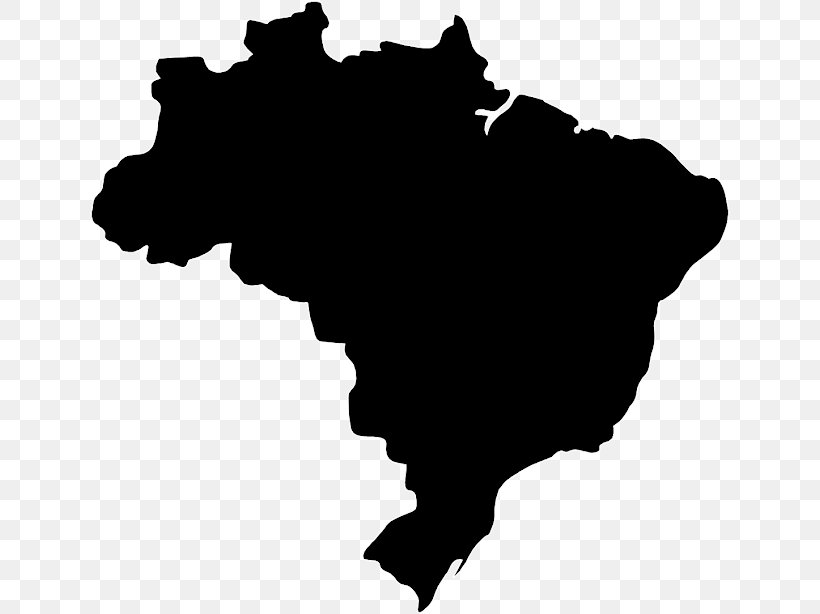



Image after removing pixels which weren't black RGB(0, 0, 0) nor white RGB(255, 255, 255)


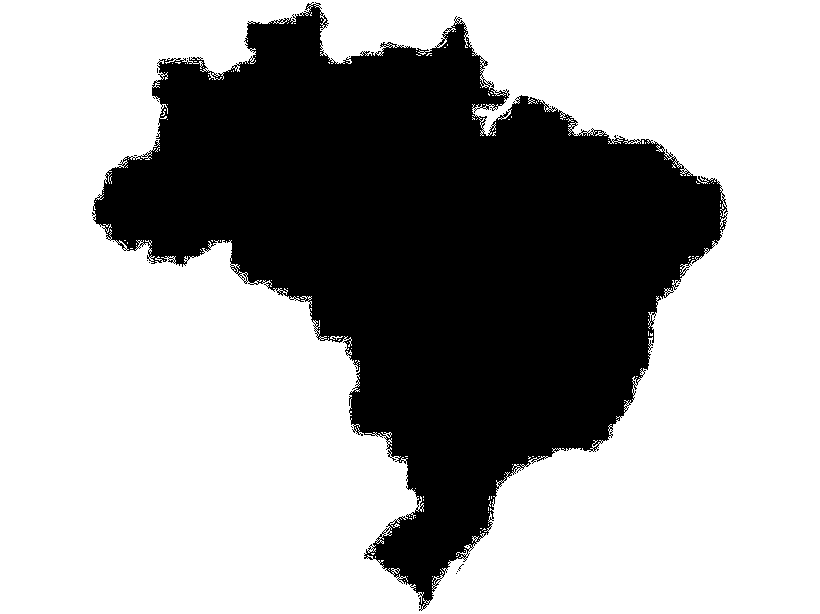



Total time for the processing:  6.0 s


In [317]:
image = Image.open('brazil_black_white.jpg')
print("Image before processing:")
display(image);

to = time.time()
for w in range(image.width):
    for h in range(image.height):
        if image.getpixel((w, h)) != (0, 0, 0): #Convert everything that's not black to white
            image.putpixel((w, h), (255, 255, 255))

print("\n\nImage after removing pixels which weren't black RGB(0, 0, 0) nor white RGB(255, 255, 255)")
display(image)
print("\n\nTotal time for the processing: ", f'{round((time.time() - to), 0)} s')

#### I'll try improving a bit more the image's edges quality so that the wordcloud looks a little prettier

I came with the below technique trying to map the location, on a set height position of the image, of the first black pixel and the first black pixel coming from the right end (in other words, backwards). So, if I find both black pixels, i could asume that whats between them should be also black since I'm talking about a surface. So, I converted everything else between those pixels to black RGB(255, 255, 255). I repeated the same process setting the width position and running through the height for the determined width.

I'm not sure if this methodology is already known (must be) but I'm pretty happy with the results obtained, although there must be a more efficient way to loop through the image's pixels.

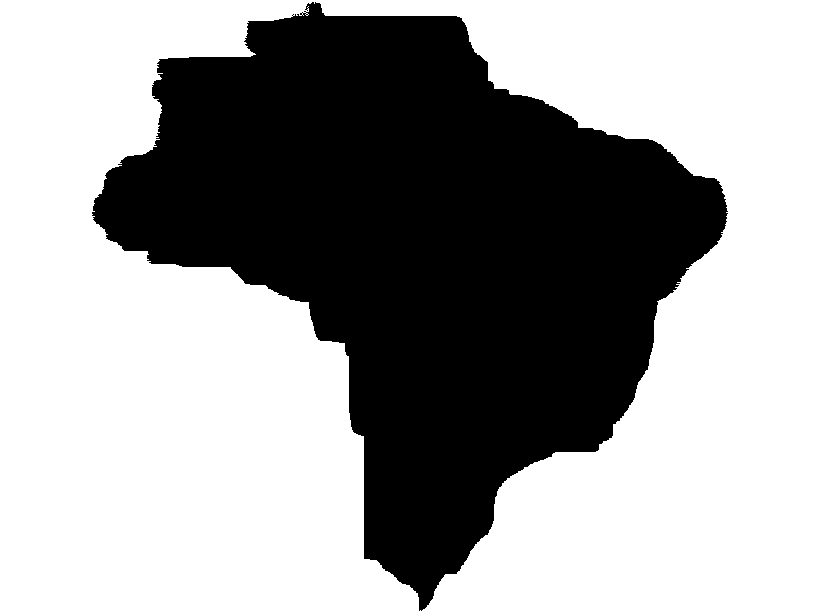



Total time for the processing:  6.0 s


In [319]:
to = time.time()
def edge_treatment(image, orient='w'):
    if orient == 'w':
        for h in range(image.height):
            key1, key2 = True, True

            for w, w_ in zip(range(image.width), range(image.width - 1, -1, -1)):

                if image.getpixel((w, h)) == (0, 0, 0) and key1:
                    begin = w
                    key1 = False

                if image.getpixel((w_, h)) == (0, 0, 0) and key2:
                    end = w_
                    key2 = False

                if key1 == False and key2 == False:
                    if w < w_:
                        for wid in range(begin, end):
                            image.putpixel((wid, h), (0, 0, 0))
                        break
                    else:
                        for wid in range(end, begin):
                            image.putpixel((wid, h), (0, 0, 0))
                        break
        return image
        
    elif orient == 'h':
        for w in range(image.width):
            key1, key2 = True, True

            for h, h_ in zip(range(image.height), range(image.height - 1, -1, -1)):

                if image.getpixel((w, h)) == (0, 0, 0) and key1:
                    begin = h
                    key1 = False

                if image.getpixel((w, h_)) == (0, 0, 0) and key2:
                    end = h_
                    key2 = False

                if key1 == False and key2 == False:
                    if h < h_:
                        for hei in range(begin, end):
                            image.putpixel((w, hei), (0, 0, 0))
                        break
                    else:
                        for wid in range(end, begin):
                            image.putpixel((w, hei), (0, 0, 0))
                        break
        return image
                
image = edge_treatment(image, orient='w')
image = edge_treatment(image, orient='h')
display(image)
# image.save('processed_image.png')
print("\n\nTotal time for the processing: ", f'{round((time.time() - to), 0)} s')

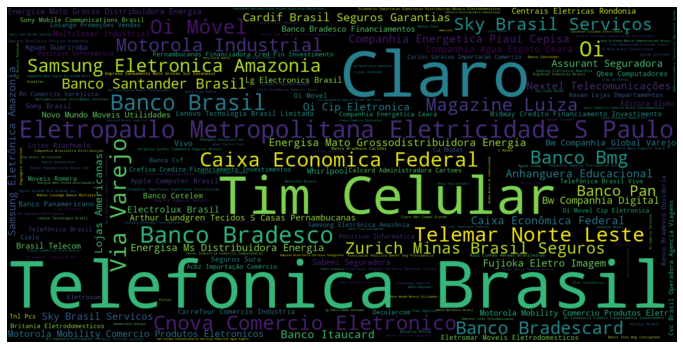

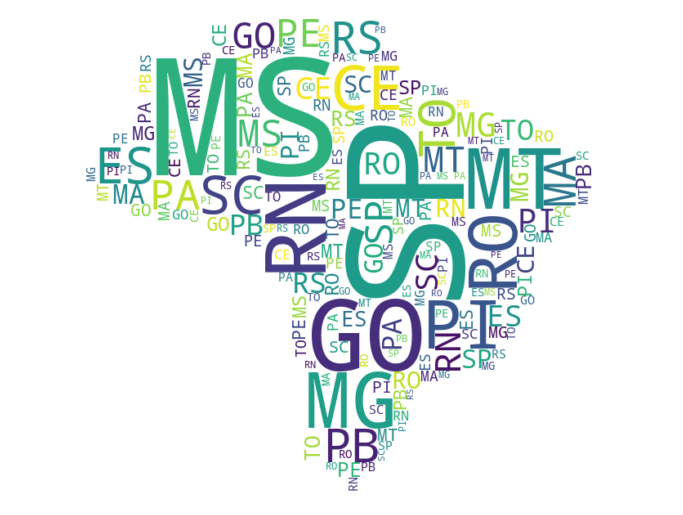

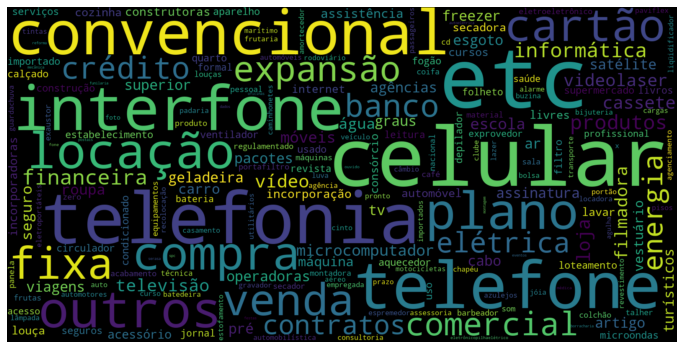

In [307]:
#Creating the Wordclouds
brazil_mask = np.array(image)
for col in processed_df.columns:
    if col == 'serviço':
        word_list = [word for row in processed_df.serviço.values for word in row]
        word_count = Counter(word_list)
        wordcloud = WordCloud(width=1600, height=800, max_font_size=200)
        cloud = wordcloud.fit_words(word_count)
        
    elif col == 'estado':
        word_count = Counter(processed_df[col].values)
        wordcloud = WordCloud(width=1600, height=800, max_font_size=200,
                              mask=brazil_mask, contour_width=1, contour_color='white',
                              background_color='white', repeat=True)
        cloud = wordcloud.fit_words(word_count)
    else:
        word_count = Counter(processed_df[col].values)
        wordcloud = WordCloud(width=1600, height=800, max_font_size=200)
        cloud = wordcloud.fit_words(word_count)

    plt.figure(figsize=(12,10))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show();

### Let's try to evaluate the different kinds of services in the dataset using LDA (Latent Dirichlet Allocation)

In [286]:
corpus = processed_df.serviço.apply(lambda x: ' '.join(x)).values

# vectorizer = CountVectorizer(ngram_range=(2, 2))
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

['abajur', 'absorvente', 'acabamento', 'academia', 'acesso', 'acessório', 'adesivo', 'afins', 'agenciamento', 'agulha', 'agência', 'agências', 'ajinomoto', 'alarme', 'albergue', 'alcoólicas', 'alho', 'alicate', 'alimentos', 'alopático', 'ambulatório', 'amortecedor', 'ampliador', 'animais', 'anzol', 'análises', 'aparelho', 'aparelhos', 'apontador', 'aquecedor', 'ar', 'areia', 'arma', 'arquiteto', 'arquivo', 'arroz', 'artigo', 'artigos', 'assessoria', 'assinatura', 'assistência', 'associações', 'atletas', 'atmosfera', 'através', 'audiovisual', 'auditivo', 'auto', 'autoelétrica', 'automobilística', 'automotivo', 'automotores', 'automóveis', 'automóvel', 'aveia', 'azulejos', 'aço', 'açougue', 'açúcar', 'aérea', 'aéreo', 'bacalhau', 'balança', 'balão', 'banco', 'banheira', 'banheiro', 'banho', 'baralho', 'barbeador', 'barbear', 'barco', 'bares', 'barra', 'barraca', 'batedeira', 'bateria', 'batom', 'beber', 'bebidas', 'beleza', 'bens', 'bexiga', 'bicicletas', 'bico', 'bijuteria', 'bilhetes',

In [291]:
to = time.time()
model = LatentDirichletAllocation(
    n_components=5,
    max_iter=300)
lda = model.fit_transform(data_vectorized)
print("Total time for training: ", str(datetime.timedelta(seconds=round(time.time() - to, 0))))

Total time for training:  2102 days, 8:16:35.066071


In [293]:
panel = pyLDAvis.sklearn.prepare(model, data_vectorized, vectorizer)
pyLDAvis.display(panel)

#### Let's try using the GridSearchCV class and try finding the best parameters for the problem

In [298]:
to = time.time()
search_params = {'n_components': [4, 5, 6, 7, 8], 'max_iter': [100, 200]}

new_model = LatentDirichletAllocation()

new_lda = GridSearchCV(new_model, param_grid=search_params)
new_lda.fit(data_vectorized)
print("Total time for training: ", str(datetime.timedelta(seconds=round(time.time() - to, 0))))

C:\ProgramData\Anaconda3_2019.10\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Total time for training:  5:44:47


In [300]:
new_lda.best_params_

{'max_iter': 100, 'n_components': 8}

In [302]:
panel = pyLDAvis.sklearn.prepare(new_lda.best_estimator_, data_vectorized, vectorizer)
pyLDAvis.display(panel)

#### From the above results I was not able to give a precise name for the services provided in each topic. Perhaps if I increase the number of components I might be able to differentiate the types of services.

In [308]:
to = time.time()
search_params = {'n_components': [8, 9, 10, 15, 20], 'max_iter': [100, 200, 300]}

new_model = LatentDirichletAllocation()

new_lda = GridSearchCV(new_model, param_grid=search_params)
new_lda.fit(data_vectorized)
print("Total time for training: ", str(datetime.timedelta(seconds=round(time.time() - to, 0))))

C:\ProgramData\Anaconda3_2019.10\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Total time for training:  14:24:02


#### Let's get the best parameters

In [309]:
new_lda.best_params_

{'max_iter': 300, 'n_components': 20}

#### Let's visualize the topics

In [310]:
panel = pyLDAvis.sklearn.prepare(new_lda.best_estimator_, data_vectorized, vectorizer)
pyLDAvis.display(panel)

#### I'm still unable to differentiate precisely all the topics, but from the best results provided by the GridSearchCV class I was able to tag the below services:

Topic 1 - Serviços de operadoras telefônicas;
Topic 2 - Serviço de plano telefônico;
Topic 3 - Serviço televisivo;
Topic 4 - Serviço bancário;
Topic 5 - Serviço de bens de consumo não duráveis;
Topic 6 - Agências de viagens;
Topic 8 - Venda/aluguél de filmes;
Topic 11 - Estabelecimentos;
Topic 12 - Serviço de ar-condicionado;
Topic 14 - Venda de móveis;
Topic 16 - Produtos de uso pessoal;
Topic 18 - Supermercado;
Topic 19 - Venda de veículos;
Topic 20 - Serviços de Lazer;

In [327]:
lda_output = new_lda.best_estimator_.transform(data_vectorized)

#### Let's check each instances' dominant topic by creating a Styler object that highlights the topic with the highest contribution rate

In [422]:
topic_names = ["Topic " + str(i) for i in range(1, new_lda.best_estimator_.n_components + 1)] # Get the topics list
instance_names = ["Inst. " + str(i) for i in range(df.shape[0])] # Get the instance's names
df_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=instance_names)
df_topic['Dominant Topic'] = df_topic.idxmax(axis=1) # Get the topic with the highest contribution to each instance

def highlight_max(s): # Function that highlights the maximum value for the row
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Let's create the Styler object
df_topic.head().style.apply(highlight_max, axis=1, subset=pd.IndexSlice[:, df_topic.columns.tolist()[:-1]]) #Get the 5 first

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Dominant Topic
Inst. 0,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.680000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,Topic 13
Inst. 1,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.880000,0.010000,0.010000,0.010000,0.010000,Topic 16
Inst. 2,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.680000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,Topic 10
Inst. 3,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.840000,0.010000,0.010000,0.010000,Topic 17
Inst. 4,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.880000,0.010000,0.010000,0.010000,0.010000,Topic 16
